things to check: 
number of lemma
number of stop words
average post length by words and characters and sentences
average comment length by words and characters and sentences
average number of comments per post
post and comment density with respect to time
average word length
average sentence length
lexile levels
most common words
posts per link flair css class

In [128]:
import spacy
import pandas as pd
import en_core_web_sm
import matplotlib.pyplot as plt
import re
from scipy import stats
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import plot_tree

pd.options.display.max_colwidth=500
elif_comments = pd.read_csv('./dataframes/elif_comments')
elip_comments = pd.read_csv('./dataframes/elip_comments')

In [129]:
nlp = en_core_web_sm.load()

# Some Cleaning

In [130]:
# filters to comments with a nested level of 1
elif_comments = elif_comments[elif_comments['parent_id'].str.startswith('t3_')]
elip_comments = elip_comments[elip_comments['parent_id'].str.startswith('t3_')]

elif_comments.shape, elip_comments.shape

((1638, 9), (1547, 9))

In [131]:
# filters out some racial and homorphobic slurs
elip_comments = elip_comments[elip_comments['body'].map(lambda s: 'faggot' not in s.lower())]
elif_comments = elif_comments[elif_comments['body'].map(lambda s: 'faggot' not in s.lower())]
elip_comments = elip_comments[elip_comments['body'].map(lambda s: 'nigger' not in s.lower())]
elif_comments = elif_comments[elif_comments['body'].map(lambda s: 'nigger' not in s.lower())]

elif_comments.shape, elip_comments.shape

((1638, 9), (1545, 9))

In [132]:
# given dataframe return dataframe with comment word count
def word_count(df):
    df['word_count'] = df['body'].map(lambda s: len(s.split(' ')))
    return df

elif_comments = word_count(elif_comments)
elip_comments = word_count(elip_comments)

In [133]:
# removes posts of fewer than 5 words
elif_comments = elif_comments[elif_comments['word_count'] >= 5]
elip_comments = elip_comments[elip_comments['word_count'] >= 5]

elif_comments.shape, elip_comments.shape

((1313, 10), (1232, 10))

In [134]:
# filters out posts made by the automoderator
elif_comments = elif_comments[elif_comments['author'] != 'AutoModerator']

elif_comments.shape, elip_comments.shape

((1152, 10), (1232, 10))

In [135]:
elif_comments = elif_comments[elif_comments['body'].map(lambda s: 'Your submission has been removed' not in s)]

In [136]:
# given dataframe return dataframe with comment character count
def char_count(df):
    df['char_count'] = df['body'].map(len)
    return df

elif_comments = char_count(elif_comments)
elip_comments = char_count(elip_comments)

In [137]:
# given dataframe return dataframe with comment sentence count
# help from https://stackoverflow.com/questions/4998629/split-string-with-multiple-delimiters-in-python
# and here: https://stackoverflow.com/questions/3675144/regex-error-nothing-to-repeat
def sentence_count(df):
    df['sentence_count'] = [len(re.split('[.] |[?] |[!] ', s)) for s in df['body']]
    return df
elif_comments = sentence_count(elif_comments)
elip_comments = sentence_count(elip_comments) 

In [138]:
# given dataframe return dataframe with average word length for comments
def word_length(df):
    word_list = [s.split(' ') for s in df['body']]
    return [len(word) for word in word_list].mean()

In [139]:
elif_comments['average_word_length'] = elif_comments['char_count'] / elif_comments['word_count']
elip_comments['average_word_length'] = elip_comments['char_count'] / elip_comments['word_count']

In [140]:
# trimming down to 1000 comments from each subreddit
elif_comments = elif_comments.head(1000)
elip_comments = elip_comments.head(1000)

In [141]:
# not sure if the count vectorizer will automatically strip line breaks

elif_comments['body'] = elif_comments['body'].map(lambda s: s.replace('\n', ' '))
elip_comments['body'] = elip_comments['body'].map(lambda s: s.replace('\n', ' '))

In [142]:
# create one dataframe with both elif_columns and elip_columns
df = pd.concat([elif_comments, elip_comments])
df.shape

(2000, 13)

In [143]:
df.isna().sum()

Unnamed: 0              0
index                   0
subreddit               0
body                    0
retrieved_on           14
created_utc             0
parent_id               0
id                      0
author                  0
word_count              0
char_count              0
sentence_count          0
average_word_length     0
dtype: int64

In [144]:
df.drop(columns = ['Unnamed: 0', 'retrieved_on', 'created_utc', 'parent_id', 'id', 'author', 'index'], inplace = True)
df.head()

,subreddit,body,word_count,char_count,sentence_count,average_word_length
1,explainlikeimfive,"It's because a bit of energy is saved in capacitors (a little kind of battery) in the electronic circuit. When we turn off the electric device the energy saved is used by the device, but the capacitor has a minimum capacity, for this reason is short the time.",48,259,2,5.395833
5,explainlikeimfive,"Some comments handled the compensation aspect. Now for the promotion part, it can depend based on the industry. I work fast food for instance. We have an arrangement with a local charity to get donations from customers, which is then matched by the business. We also give out small coupons for free cheap items, or dollar discounts on combo meals or something. I don’t know if we have a different place that prints those for us, as opposed to the regular compensation cards we hand out, but that’...",110,615,8,5.590909
10,explainlikeimfive,"It's a far right wing conspiracy which was initially proposed on 4chan from a person names ""Qanon"". They gave evidence claiming they are working inside the government about how the democratic party and multiple left/liberal figures purposefuly wanted to take down Trump by all means nescarry because he was a threat to their plans to take over America. Every since then it has evloved into what can only be described as a internet cult with them believing that there is a secret sex trafficking o...",190,1113,6,5.857895
13,explainlikeimfive,"One problem is getting enough oxygen and hydrogen together to make a practicable amount of water to solve a water shortage. If you're transporting them then not only do they tend to take up more space then just transporting water, they're both potentially dangerous substances in their pure, concentrated forms. Another problem is that in order to combine the two you need energy to do it (burn them). This can also have the nasty side affect of basically creating an explosion so it has to be a...",122,714,3,5.852459
17,explainlikeimfive,"Well the Laws of thermodynamics are also ""just"" a theory, the keyword here being just. In science a theory does not mean the same as the everyday word. In fact that the theories CAN be disproven is what makes them so valuable. If you talk with a flat earther or an anti vaxer or trump. Nothing you say can disprove them, as your proof is just some conspiracy of planted evidence, 5g networks or fake news trying to undermine them. Whereas in actual science, if you could show that under some ...",148,861,7,5.817568


In [145]:

df.head()

,subreddit,body,word_count,char_count,sentence_count,average_word_length
1,explainlikeimfive,"It's because a bit of energy is saved in capacitors (a little kind of battery) in the electronic circuit. When we turn off the electric device the energy saved is used by the device, but the capacitor has a minimum capacity, for this reason is short the time.",48,259,2,5.395833
5,explainlikeimfive,"Some comments handled the compensation aspect. Now for the promotion part, it can depend based on the industry. I work fast food for instance. We have an arrangement with a local charity to get donations from customers, which is then matched by the business. We also give out small coupons for free cheap items, or dollar discounts on combo meals or something. I don’t know if we have a different place that prints those for us, as opposed to the regular compensation cards we hand out, but that’...",110,615,8,5.590909
10,explainlikeimfive,"It's a far right wing conspiracy which was initially proposed on 4chan from a person names ""Qanon"". They gave evidence claiming they are working inside the government about how the democratic party and multiple left/liberal figures purposefuly wanted to take down Trump by all means nescarry because he was a threat to their plans to take over America. Every since then it has evloved into what can only be described as a internet cult with them believing that there is a secret sex trafficking o...",190,1113,6,5.857895
13,explainlikeimfive,"One problem is getting enough oxygen and hydrogen together to make a practicable amount of water to solve a water shortage. If you're transporting them then not only do they tend to take up more space then just transporting water, they're both potentially dangerous substances in their pure, concentrated forms. Another problem is that in order to combine the two you need energy to do it (burn them). This can also have the nasty side affect of basically creating an explosion so it has to be a...",122,714,3,5.852459
17,explainlikeimfive,"Well the Laws of thermodynamics are also ""just"" a theory, the keyword here being just. In science a theory does not mean the same as the everyday word. In fact that the theories CAN be disproven is what makes them so valuable. If you talk with a flat earther or an anti vaxer or trump. Nothing you say can disprove them, as your proof is just some conspiracy of planted evidence, 5g networks or fake news trying to undermine them. Whereas in actual science, if you could show that under some ...",148,861,7,5.817568


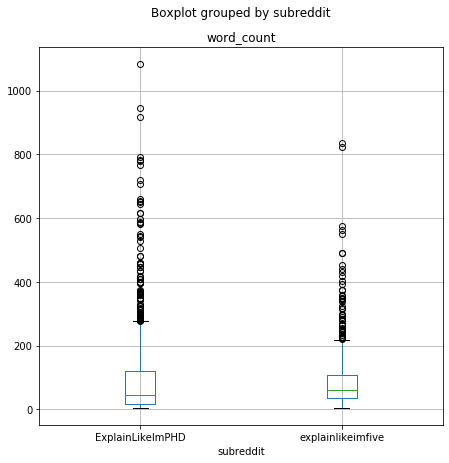

In [146]:
df.boxplot('word_count', by = 'subreddit', figsize = (7, 7))

In [147]:
colors = {'red', 'blue'}

Text(0.5, 1.0, 'Average Word Count per Comment')

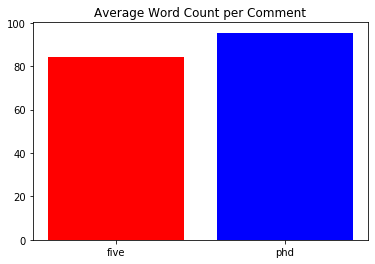

In [148]:
# compare status lengths by word count
plt.bar(['five', 'phd'], 
        [elif_comments['word_count'].mean(), elip_comments['word_count'].mean()],
       color = colors);
plt.title('Average Word Count per Comment')

In [149]:
# from GL 4.06
# The difference in word count is statistically significant. So is characater count and sentence count
stats.ttest_ind(elif_comments['word_count'], elip_comments['word_count'], equal_var = False).pvalue

0.026323573828002475

In [150]:
stats.ttest_ind(elif_comments['char_count'], elip_comments['char_count'], equal_var = False).pvalue

0.002203061223879429

In [151]:
stats.ttest_ind(elif_comments['sentence_count'], elip_comments['sentence_count'], equal_var = False).pvalue

0.004868564661836086

In [152]:
stats.ttest_ind(elif_comments['average_word_length'], elip_comments['average_word_length'], equal_var = False).pvalue

2.4931997542276306e-05

In [153]:
elif_comments.describe()

,Unnamed: 0,index,retrieved_on,created_utc,word_count,char_count,sentence_count,average_word_length
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000
mean,1795.963000,50.463000,1.595418e+09,1.595338e+09,84.451000,482.381000,4.07900,5.793264
std,1098.629059,28.959373,2.305338e+04,2.560633e+04,82.563687,468.018696,3.64253,0.840013
min,1.000000,0.000000,1.595374e+09,1.595287e+09,5.000000,27.000000,1.00000,4.125000
25%,854.250000,27.000000,1.595397e+09,1.595314e+09,34.000000,196.000000,2.00000,5.352544
50%,1773.500000,51.000000,1.595419e+09,1.595344e+09,61.000000,343.000000,3.00000,5.680625
75%,2769.000000,75.250000,1.595436e+09,1.595358e+09,108.250000,622.250000,5.00000,6.033122
max,3639.000000,99.000000,1.595458e+09,1.595378e+09,836.000000,4843.000000,43.00000,14.600000


In [154]:
elip_comments.describe()

,Unnamed: 0,index,retrieved_on,created_utc,word_count,char_count,sentence_count,average_word_length
count,1000.000000,1000.000000,9.860000e+02,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,1453.886000,48.286000,1.468187e+09,1.466528e+09,95.436000,572.592000,4.675000,6.085508
std,867.128709,28.904735,4.534245e+07,4.594102e+07,132.640776,804.037863,5.605604,2.016675
min,1.000000,0.000000,1.427862e+09,1.426800e+09,5.000000,10.000000,1.000000,1.000000
25%,688.750000,24.000000,1.432758e+09,1.430901e+09,16.000000,97.000000,1.000000,5.315414
50%,1466.000000,48.000000,1.450042e+09,1.448596e+09,44.000000,267.500000,3.000000,5.815873
75%,2222.250000,73.000000,1.488686e+09,1.488607e+09,120.000000,736.250000,5.250000,6.275838
max,2908.000000,99.000000,1.594642e+09,1.594642e+09,1084.000000,6803.000000,44.000000,35.181818


Text(0.5, 1.0, 'Average Character Count per Comment')

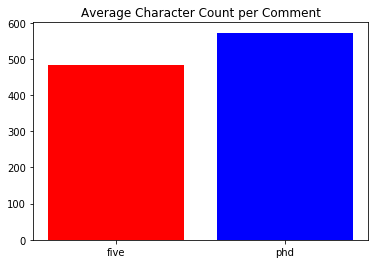

In [155]:
plt.bar(['five', 'phd'], 
        [elif_comments['char_count'].mean(), elip_comments['char_count'].mean()],
       color = colors);
plt.title('Average Character Count per Comment')

Text(0.5, 1.0, 'Average Sentence Count per Comment')

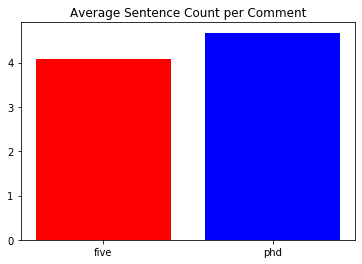

In [156]:
plt.bar(['five', 'phd'], 
        [elif_comments['sentence_count'].mean(), elip_comments['sentence_count'].mean()],
       color = colors);
plt.title('Average Sentence Count per Comment')

Text(0.5, 1.0, 'Average Words per Sentence')

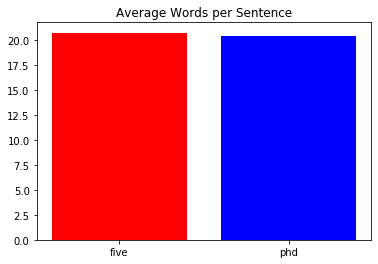

In [157]:
plt.bar(['five', 'phd'], 
        [elif_comments['word_count'].mean()/elif_comments['sentence_count'].mean(), 
         elip_comments['word_count'].mean()/elip_comments['sentence_count'].mean()],
       color = colors);
plt.title('Average Words per Sentence')

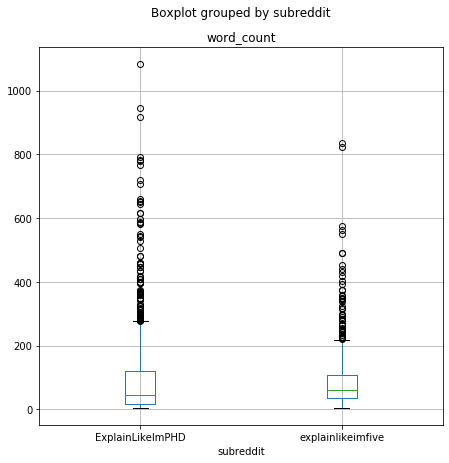

In [158]:
df.boxplot('word_count', by = 'subreddit', figsize = (7, 7))

Text(0.5, 1.0, 'Average Word Length')

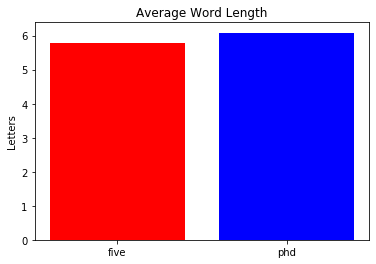

In [159]:
plt.bar(['five', 'phd'], 
        [elif_comments['average_word_length'].mean(),
         elip_comments['average_word_length'].mean()],
       color = colors);
plt.ylabel('Letters')
plt.title('Average Word Length')

Text(0.5, 1.0, 'Percent of Comments Removed or Deleted')

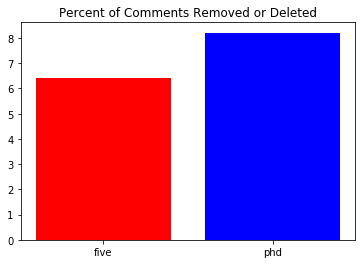

In [160]:
plt.bar(['five', 'phd'], [100-1111/1187*100, 100-1420/1547*100], color = colors);
plt.title('Percent of Comments Removed or Deleted')

In [161]:
elif_comments.describe()

,Unnamed: 0,index,retrieved_on,created_utc,word_count,char_count,sentence_count,average_word_length
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000
mean,1795.963000,50.463000,1.595418e+09,1.595338e+09,84.451000,482.381000,4.07900,5.793264
std,1098.629059,28.959373,2.305338e+04,2.560633e+04,82.563687,468.018696,3.64253,0.840013
min,1.000000,0.000000,1.595374e+09,1.595287e+09,5.000000,27.000000,1.00000,4.125000
25%,854.250000,27.000000,1.595397e+09,1.595314e+09,34.000000,196.000000,2.00000,5.352544
50%,1773.500000,51.000000,1.595419e+09,1.595344e+09,61.000000,343.000000,3.00000,5.680625
75%,2769.000000,75.250000,1.595436e+09,1.595358e+09,108.250000,622.250000,5.00000,6.033122
max,3639.000000,99.000000,1.595458e+09,1.595378e+09,836.000000,4843.000000,43.00000,14.600000


In [162]:
elip_comments.describe()

,Unnamed: 0,index,retrieved_on,created_utc,word_count,char_count,sentence_count,average_word_length
count,1000.000000,1000.000000,9.860000e+02,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,1453.886000,48.286000,1.468187e+09,1.466528e+09,95.436000,572.592000,4.675000,6.085508
std,867.128709,28.904735,4.534245e+07,4.594102e+07,132.640776,804.037863,5.605604,2.016675
min,1.000000,0.000000,1.427862e+09,1.426800e+09,5.000000,10.000000,1.000000,1.000000
25%,688.750000,24.000000,1.432758e+09,1.430901e+09,16.000000,97.000000,1.000000,5.315414
50%,1466.000000,48.000000,1.450042e+09,1.448596e+09,44.000000,267.500000,3.000000,5.815873
75%,2222.250000,73.000000,1.488686e+09,1.488607e+09,120.000000,736.250000,5.250000,6.275838
max,2908.000000,99.000000,1.594642e+09,1.594642e+09,1084.000000,6803.000000,44.000000,35.181818


In [163]:
#  dummifies target category
df['subreddit'] = df['subreddit'].map(lambda s: int(s.lower() == 'explainlikeimphd'))

# Prepare Model

In [164]:
X = df.copy()
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 37)

In [165]:
cvec = CountVectorizer(stop_words = 'english')

elif_train = X_train[X_train['subreddit'] == 0]
elip_train = X_train[X_train['subreddit'] == 1]

elip_train = cvec.fit_transform(elip_train['body'])

elip_train_df = pd.DataFrame(elip_train.toarray(),
                          columns=cvec.get_feature_names())

top_words_elip = {}

# loop through columns
for i in elip_train_df.columns:
    # save sum of each column in dictionary
    top_words_elip[i] = elip_train_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_elip = pd.DataFrame(sorted(top_words_elip.items(), key = lambda x: x[1], reverse = True))

elif_train = cvec.fit_transform(elif_train['body'])

elif_train_df = pd.DataFrame(elif_train.toarray(),
                          columns=cvec.get_feature_names())

top_words_elif = {}

# loop through columns
for i in elif_train_df.columns:
    # save sum of each column in dictionary
    top_words_elif[i] = elif_train_df[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_elif = pd.DataFrame(sorted(top_words_elif.items(), key = lambda x: x[1], reverse = True))

In [166]:
most_freq_elif.head(25)

,0,1
0,like,227
1,just,219
2,people,181
3,time,157
4,water,149
5,don,138
6,heat,127
7,make,123
8,way,120
9,lot,107


In [167]:
most_freq_elip.head(25)

,0,1
0,like,243
1,time,167
2,just,145
3,people,132
4,light,118
5,don,115
6,way,110
7,think,106
8,https,105
9,energy,100


In [176]:
X_train = X_train['body']
X_test = X_test['body']

In [177]:
# Logistic Regression with LASSO regularization. gridsearched over differed C values to try to find best one
# l1_pipe = Pipeline([
#     ('cvec', CountVectorizer(stop_words = 'english')),
#     ('lr', LogisticRegressionCV(penalty = 'l1', solver = 'liblinear',  random_state = 37))
# ])

# log_params = {
#     'lr__Cs': [2, 4, 10, 15],
#     'cvec__max_features': [3000, 4000, 5000],
#     'cvec__min_df': [2, 3],
#     'cvec__ngram_range': [(1, 1), (1, 2)]
# }


# l1_gs = GridSearchCV(l1_pipe, log_params, cv = 4, verbose = 1)
# l1_gs.fit(X_train, y_train)
# l1_gs.score(X_train, y_train), l1_gs.score(X_test, y_test)

In [178]:
l1_gs.best_params_
# some of my features are at the top end so i'll try a search where I go higher

{}

In [179]:
# second and third try with different parameters. the test score of .75 is better than previous of .71
l1_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', ngram_range = (1,2), max_features = 100000)),
#     ('ssc', StandardScaler()),
    ('lr', LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', Cs = 30,  random_state = 37, cv = 5))
])

# I have commented out the parameters that I searched on my second attempt and made a more narrow search.
# Afterwards, I added the best parameters into the pipeline
log_params = {

#     'lr__Cs': [15, 20, 50],
#     'lr__Cs': [20, 30, 40],
#     'cvec__max_features': [None, 5000, 10000],
#     'cvec__max_features': [10000, 20000, 30000],
#     'cvec__max_features': [30000, 50000, 100000]
#     'cvec__min_df': [1,2]
    
}


l1_gs = GridSearchCV(l1_pipe, log_params, cv = 5, verbose = 1)
l1_gs.fit(X_train, y_train)
l1_gs.score(X_train, y_train), l1_gs.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished


(1.0, 0.708)

# lr.coef_

In [172]:
l1_gs.best_params_

{}

In [185]:
# fails to converge. needs attention
l2_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 4000, ngram_range = (1,2), min_df = 2)),
    ('lr', LogisticRegressionCV(random_state = 37, max_iter = 1000, Cs = 4))
])

log_params = {
#     'lr__Cs': [2, 4, 10, 15],
#     'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [1,2],
#     'cvec__ngram_range': [(1, 1), (1, 2)]
}

# l2_gs = GridSearchCV(l2_pipe, log_params, cv =4, verbose = 1)
# l2_gs.fit(X_train, y_train)
# l2_gs.score(X_train, y_train), l2_gs.score(X_test, y_test)
l2_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=4000, min_df=2,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegressionCV(Cs=4, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=1000, multi_class='auto',
               

In [ ]:
l2_gs.best_params_

In [ ]:
# does not work yet. will debug if time


# en_pipe = Pipeline([
#     ('cvec', CountVectorizer(stop_words = 'english')),
#     ('lr', LogisticRegressionCV(penalty = 'elasticnet', solver = 'saga', random_state = 37))
# ])

# en_gs = GridSearchCV(en_pipe, log_params, cv = 4, verbose = 1)
# en_gs.fit(X_train, y_train)
# en_gs.score(X_train, y_train), en_gs.score(X_test, y_test)

In [186]:
# decision tree. I reduced some hyperparamters for cvecbecause it was taking too long to run

tree_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2)),
    ('d_tree', DecisionTreeClassifier(random_state = 37, max_depth = 7)),    
])

dt_params = {
#     'd_tree__min_samples_split': [5, 10, 15, 20],
    'd_tree__min_samples_split': [2, 3, 5],
#     'd_tree__min_samples_leaf': [2, 3, 4, 5, 6],
    'd_tree__min_samples_leaf': [1,2],
#     'd_tree__ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
#     'cvec__ngram_range': [(1, 1), (1, 2)]
}
d_tree_gs = GridSearchCV(tree_pipe, dt_params, cv = 4, verbose = 1)
d_tree_gs.fit(X_train, y_train)
d_tree_gs.score(X_train, y_train), d_tree_gs.score(X_test, y_test)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.9s finished


(0.616, 0.582)

In [187]:
tree_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2)),
    ('d_tree', DecisionTreeClassifier(random_state = 37, max_depth = 7, min_samples_leaf = 2)),    
])
tree_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('d_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=7,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
           

In [188]:
# the variance on this model is pretty decent. I will not try another grid search
d_tree_gs.best_params_

{'d_tree__min_samples_leaf': 1, 'd_tree__min_samples_split': 2}

In [189]:
# bagged decision trees

bagger_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english',)),
    ('bagger', BaggingClassifier(random_state = 37))
])

bag_params = {
    'bagger__n_estimators': [50, 100, 200],
#     'cvec__max_features': [3000, 4000, 5000],
    'cvec__max_features': [1000, 2000, 3000],
#     'cvec__min_df': [2, 3],
#     'cvec__ngram_range': [(1, 1), (1, 2)]
}
bagger_gs = GridSearchCV(bagger_pipe, bag_params, cv = 5, verbose = 1)
bagger_gs.fit(X_train, y_train)
bagger_gs.score(X_train, y_train), bagger_gs.score(X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  6.0min finished


(0.9986666666666667, 0.684)

In [190]:
bagger_gs.best_params_

{'bagger__n_estimators': 100, 'cvec__max_features': 3000}

In [191]:
bagger_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 3000, min_df = 2)),
    ('bagger', BaggingClassifier(random_state = 37, n_estimators = 50))
])
bagger_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=3000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('bagger',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=1.0,
                                   max_samples=1.0, n_estimators=50,
                                   n_jobs=None, oob_score=False,
                  

In [192]:
# copied from GL 6.04

gboost_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2)),
    ('gboost', GradientBoostingClassifier())
])

gboost_params = {
    'gboost__max_depth': [2,3,4],
    'gboost__n_estimators': [100, 125, 150],
    'gboost__learning_rate': [.08, .1, .12],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}
gboost_gs = GridSearchCV(gboost_pipe, param_grid=gboost_params, cv=3)
# gboost_gs.fit(X_train, y_train)
# gboost_gs.score(X_train, y_train), gboost_gs.score(X_test, y_test)

In [194]:
# not yet optimized
gboost_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2, ngram_range = (1, 2))),
    ('gboost', GradientBoostingClassifier(learning_rate = .08, max_depth = 4, n_estimators = 100))
])
gboost_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                                            learning_rate=0.08, loss='deviance',
                                            max_depth=4, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                           

In [195]:
# copied from GL 6.04

ada_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2)),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
])

ada_params = {
    'ada__n_estimators': [50,100],
    'ada__base_estimator__max_depth': [1,2],
    'ada__learning_rate': [.9, 1.],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}
ada_gs = GridSearchCV(ada_pipe, param_grid=ada_params, cv=3)
ada_gs.fit(X_train, y_train)
ada_gs.score(X_train, y_train), ada_gs.score(X_test, y_test)

(0.9613333333333334, 0.686)

In [ ]:
ada_gs.best_params_

In [196]:
ada_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2, ngram_range = (1,2))),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate = 1, n_estimators = 100))
])
ada_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                              

In [197]:
# random forest model with help from GL 6.03

rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2)),
    ('rf', RandomForestClassifier(random_state = 37))
])

rf_params = {
    'rf__max_depth': [3, 5, 7, 10],
    'rf__min_samples_split': [2,3],
    'rf__max_features': [None, 'auto'],
    'rf__n_estimators': [75, 100, 125],
    'cvec__ngram_range': [(1, 1), (1, 2)]
}
forest_gs = GridSearchCV(rf_pipe, param_grid = rf_params)
forest_gs.fit(X_train, y_train)
forest_gs.score(X_train, y_train), forest_gs.score(X_test, y_test)

(0.8753333333333333, 0.7)

In [198]:
forest_gs.best_params_

{'cvec__ngram_range': (1, 2),
 'rf__max_depth': 10,
 'rf__max_features': 'auto',
 'rf__min_samples_split': 2,
 'rf__n_estimators': 125}

In [199]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', max_features = 5000, min_df = 2)),
    ('rf', RandomForestClassifier(random_state = 37, max_depth = 10, n_estimators = 125))
])
rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=10, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                  

In [200]:
mnb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = 'english', ngram_range = (1,2))),
     ('mnb', MultinomialNB())
])
mnb_pipe.fit(X_train, y_train)
mnb_pipe.score(X_train, y_train), mnb_pipe.score(X_test, y_test)

(0.99, 0.702)

In [201]:
# Tried this. does not work

# vote = VotingClassifier([
#     ('ada', ada_gs),
#     ('grad_boost', gboost_gs),
#     ('random_forest', forest_gs),
#     ('bagger', bagger),
#     ('d_tree', d_tree_gs),
#     ('l1_pipe', l1_gs),
#     ('l2_pipe', l2_gs),
#     ('en_pipe', en_gs),
#     ('bayes', MultinomialNB())
    
# ])


In [203]:
vote = VotingClassifier([
    ('ada', ada_pipe), #.67
    ('grad_boost', gboost_pipe), #.68
    ('random_forest', rf_pipe), #.69
    ('bagger', bagger_pipe), #.716
    ('d_tree', tree_pipe), #.59
    ('l1_pipe', l1_pipe), #.75
    ('l2_pipe', l2_pipe), #.73
#     ('en_pipe', en_gs),
    ('bayes', mnb_pipe) #.75
], weights = [.08, .08, .1, .12, .02, .2, .2, .2])

vote.fit(X_train, y_train)

VotingClassifier(estimators=[('ada',
                              Pipeline(memory=None,
                                       steps=[('cvec',
                                               CountVectorizer(analyzer='word',
                                                               binary=False,
                                                               decode_error='strict',
                                                               dtype=<class 'numpy.int64'>,
                                                               encoding='utf-8',
                                                               input='content',
                                                               lowercase=True,
                                                               max_df=1.0,
                                                               max_features=5000,
                                                               min_df=2,
                                                   

In [204]:
vote.score(X_train, y_train), vote.score(X_test, y_test)

(0.9973333333333333, 0.72)

In [205]:
preds = vote.predict(X_test)
cm = confusion_matrix(y_test, preds)
cm

array([[177,  73],
       [ 67, 183]])

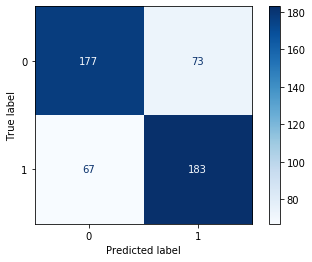

In [206]:
plot_confusion_matrix(vote, X_test, y_test, cmap = 'Blues', values_format = 'd')

In [202]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [203]:
# specificity
tn / (tn + fp)

0.756

In [204]:
# sensitivity
tp / (tp+fn)

0.756

In [215]:
test_df = pd.DataFrame(y_test)

In [216]:
preds_df = pd.DataFrame(preds)

In [223]:
test_df.shape

(500, 1)

In [225]:
preds_df.isna().sum()

0    0
dtype: int64

In [236]:
comparison = test_df.join(preds_df)

In [237]:
comparison

,subreddit,0
15,1,1.0
21,0,0.0
31,0,1.0
38,0,0.0
42,1,1.0
...,...,...
3597,0,NaN
3614,0,NaN
3617,0,NaN
3632,0,NaN


In [239]:
comparisons = pd.DataFrame(X_test).join(pd.DataFrame(comparison))

In [240]:
comparisons.isna().sum()

body           0
subreddit      0
0            456
dtype: int64

In [79]:
final_pipe.score(X_train, y_train), final_pipe.score(X_test, y_test)

(0.8586666666666667, 0.734)

In [243]:
len(y_test)

500

### 